🌐 Enter Devices (format: device_name device_type [ip_address]). Type 'done' when finished:
Device: R1 router 192.168.0.1
Device: SW1 switch 192.168.0.2
Device: PC1 pc 192.168.0.10
Device: PC2 pc 192.168.0.11
Device: FW1 firewall 192.168.0.254
Device: SRV1 server 192.168.0.100
Device: AP1 accesspoint 192.168.0.20
Device: done

🔗 Enter Connections (format: device1 device2). Type 'done' when finished:
Connection:  R1 SW1
Connection: SW1 PC2
Connection: SW1 SRV1
Connection: SW1 AP1
Connection: R1 FW1
Connection: done

📋 Devices Summary:
  - R1: Router (IP: 192.168.0.1)
  - SW1: Switch (IP: 192.168.0.2)
  - PC1: Pc (IP: 192.168.0.10)
  - PC2: Pc (IP: 192.168.0.11)
  - FW1: Firewall (IP: 192.168.0.254)
  - SRV1: Server (IP: 192.168.0.100)
  - AP1: Accesspoint (IP: 192.168.0.20)
✅ Diagram saved as 'network_diagram.png'


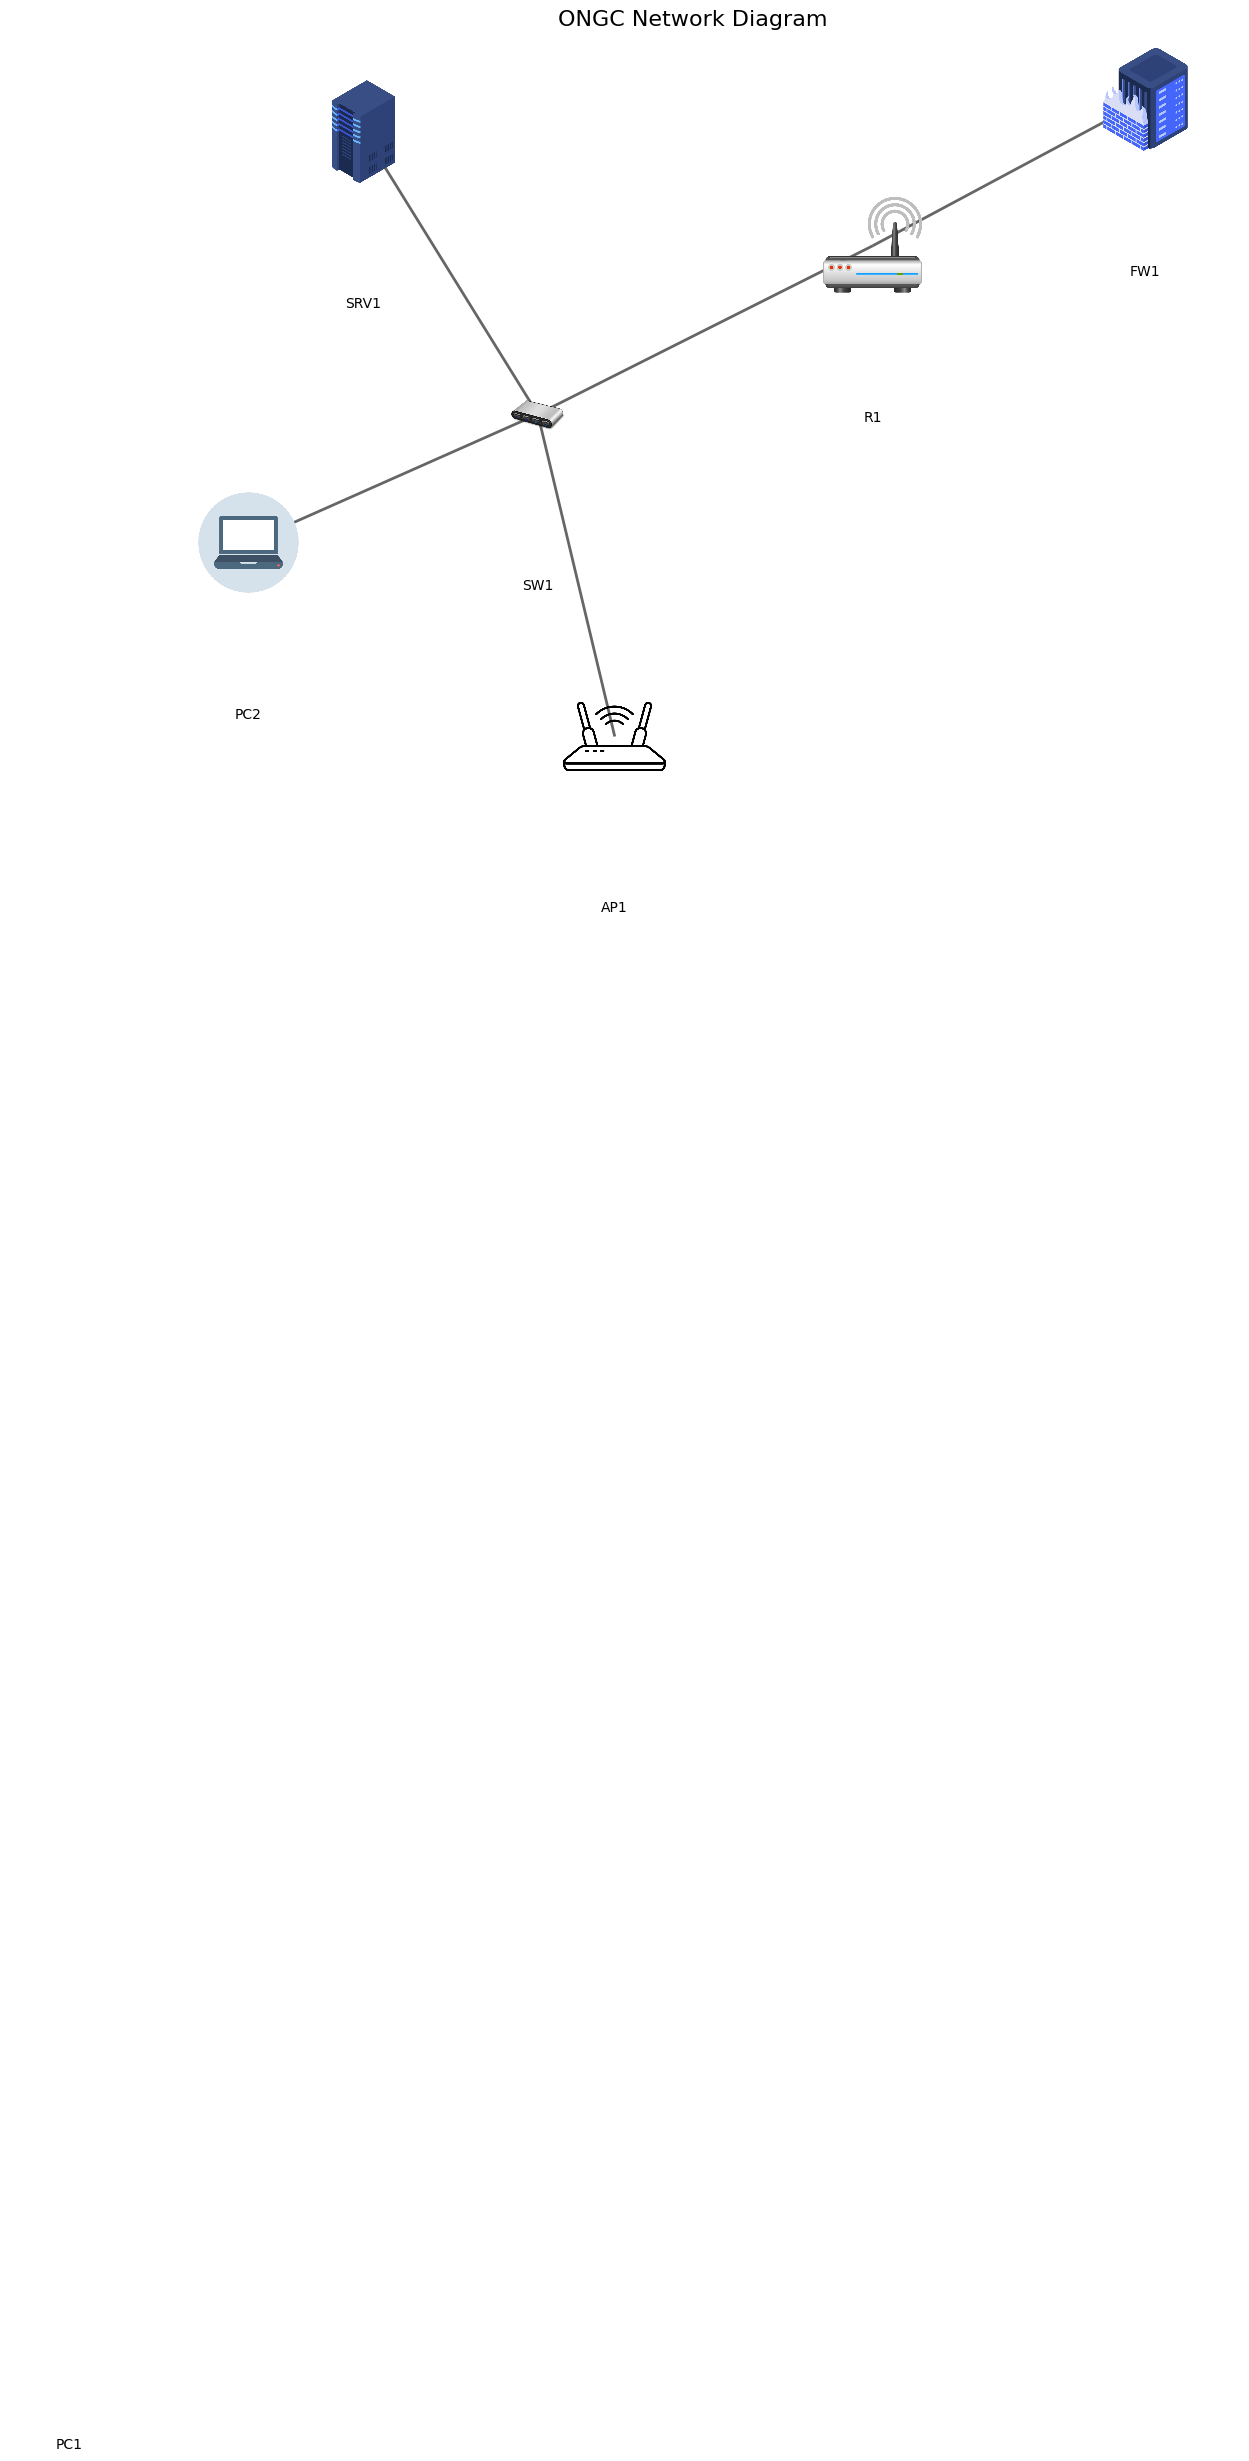

✅ Topology saved as 'network_topology.json'
✅ All network details saved to 'network_details.csv'


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import json
import os
import csv

device_icon_files = {
    'accesspoint': r"accesspoint.png",
    'firewall': r"firewall.png",
    'hub': r"hub.png",
    'ipphone': r"ipphone.png",
    'pc': r"pc.png",
    'router': r"router.png",
    'server': r"server.png",
    'switch': r"switch.png",
}

def get_icon(dev_type):
    path = device_icon_files.get(dev_type.lower(), None)
    if path is None or not os.path.exists(path):
        print(f"⚠️ Icon not found for device type '{dev_type}'")
        return None
    img = plt.imread(path)
    return img
def get_network_input():
    print("🌐 Enter Devices (format: device_name device_type [ip_address]). Type 'done' when finished:")
    devices = {}
    while True:
        entry = input("Device: ").strip()
        if entry.lower() == 'done':
            break
        parts = entry.split()
        if len(parts) >= 2:
            name = parts[0]
            dev_type = parts[1].lower()
            ip = parts[2] if len(parts) == 3 else None
            devices[name] = {'type': dev_type, 'ip': ip}
        else:
            print("❌ Invalid input! Format: device_name device_type [ip_address]")

    print("\n🔗 Enter Connections (format: device1 device2). Type 'done' when finished:")
    connections = []
    while True:
        entry = input("Connection: ").strip()
        if entry.lower() == 'done':
            break
        parts = entry.split()
        if len(parts) == 2 and parts[0] in devices and parts[1] in devices:
            connections.append((parts[0], parts[1]))
        else:
            print("❌ Invalid connection. Check device names!")

    return devices, connections

def draw_network_with_icons(devices, connections, save_image=False, filename="network_diagram.png"):
    G = nx.Graph()
    for dev, details in devices.items():
        label = f"{dev}\n({details['type']})"
        if details['ip']:
            label += f"\n{details['ip']}"
        G.add_node(dev, label=label, dev_type=details['type'])
    G.add_edges_from(connections)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(14, 10))
    ax = plt.gca()
    ax.set_title("ONGC Network Diagram ", fontsize=16)
    plt.axis('off')

    nx.draw_networkx_edges(G, pos, width=2, alpha=0.6)

    for node, (x, y) in pos.items():
        dev_type = G.nodes[node]['dev_type']
        icon_img = get_icon(dev_type)
        if icon_img is not None:
            imagebox = OffsetImage(icon_img, zoom=0.15)
            ab = AnnotationBbox(imagebox, (x, y), frameon=False)
            ax.add_artist(ab)
        else:
            nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color='gray', node_size=2000)
        ax.text(x, y - 0.1, node, fontsize=10, ha='center', va='top')

    if save_image:
        plt.savefig(filename, dpi=300)
        print(f"✅ Diagram saved as '{filename}'")
    plt.show()

def save_topology(devices, connections, filename="network_topology.json"):
    topology = {'devices': devices, 'connections': connections}
    with open(filename, 'w') as f:
        json.dump(topology, f, indent=4)
    print(f"✅ Topology saved as '{filename}'")

def save_to_csv(devices, connections, filename="network_details.csv"):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Device Name', 'Device Type', 'IP Address'])
        for name, info in devices.items():
            writer.writerow([name, info['type'], info['ip'] if info['ip'] else "N/A"])

        writer.writerow([])
        writer.writerow(['Connection From', 'Connection To'])
        for conn in connections:
            writer.writerow([conn[0], conn[1]])

    print(f"✅ All network details saved to '{filename}'")

if __name__ == "__main__":
    devices, connections = get_network_input()

    print("\n📋 Devices Summary:")
    for name, info in devices.items():
        print(f"  - {name}: {info['type'].title()} (IP: {info['ip'] if info['ip'] else 'N/A'})")

    draw_network_with_icons(devices, connections, save_image=True)
    save_topology(devices, connections)
    save_to_csv(devices, connections)


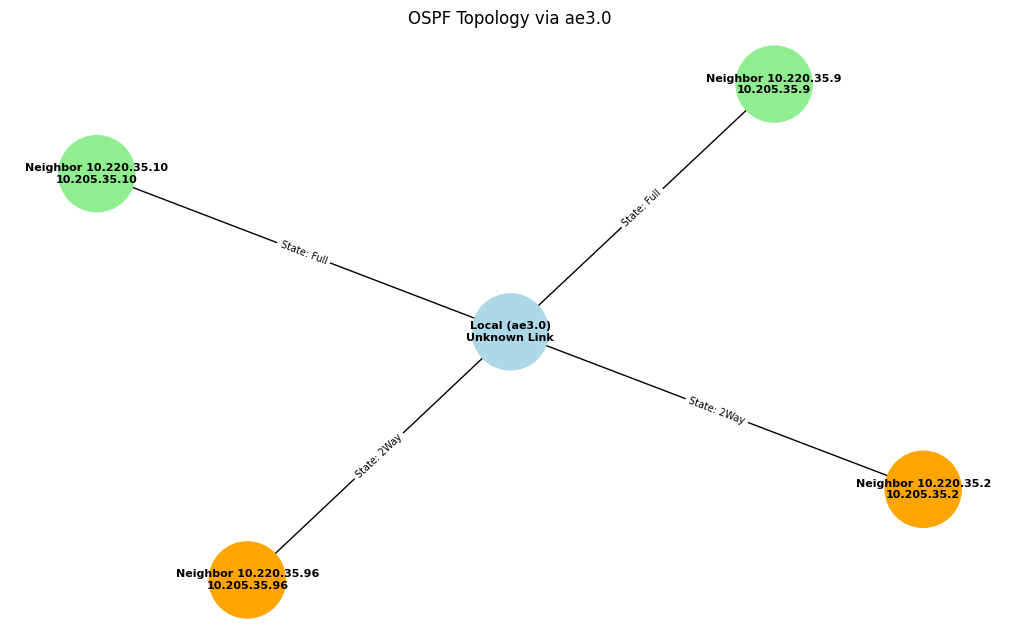

In [ ]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Load JSON files
with open('interfaces.json') as f:
    interfaces = {i['Interface']: i for i in json.load(f)}

with open('ospf_neighbors.json') as f:
    neighbors = json.load(f)

# Group neighbors by interface
grouped_by_interface = defaultdict(list)
for neighbor in neighbors:
    grouped_by_interface[neighbor['Interface']].append(neighbor)

# Generate diagrams
for interface, neigh_list in grouped_by_interface.items():
    G = nx.Graph()
    local_description = interfaces.get(interface, {}).get('Description', 'Unknown Link')

    # Add central node (local router)
    local_node = f"Local ({interface})\n{local_description}"
    G.add_node(local_node, color='lightblue')

    for neighbor in neigh_list:
        neigh_node = f"Neighbor {neighbor['ID']}\n{neighbor['Address']}"
        G.add_node(neigh_node, color='lightgreen' if neighbor['State'] == 'Full' else 'orange')
        G.add_edge(local_node, neigh_node, label=f"State: {neighbor['State']}")

    # Visualization
    pos = nx.spring_layout(G, seed=42)
    edge_labels = nx.get_edge_attributes(G, 'label')
    node_colors = [nx.get_node_attributes(G, 'color')[n] for n in G.nodes()]

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=3000, font_size=8, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.title(f"OSPF Topology via {interface}")
    plt.axis('off')
    plt.show()



Describe the network diagram you want (e.g. 'Show me the NZR DC RLTL link diagram'):
> Show me the NZR DC RLTL link diagram
✅ Found interface: ge-0/0/2.0


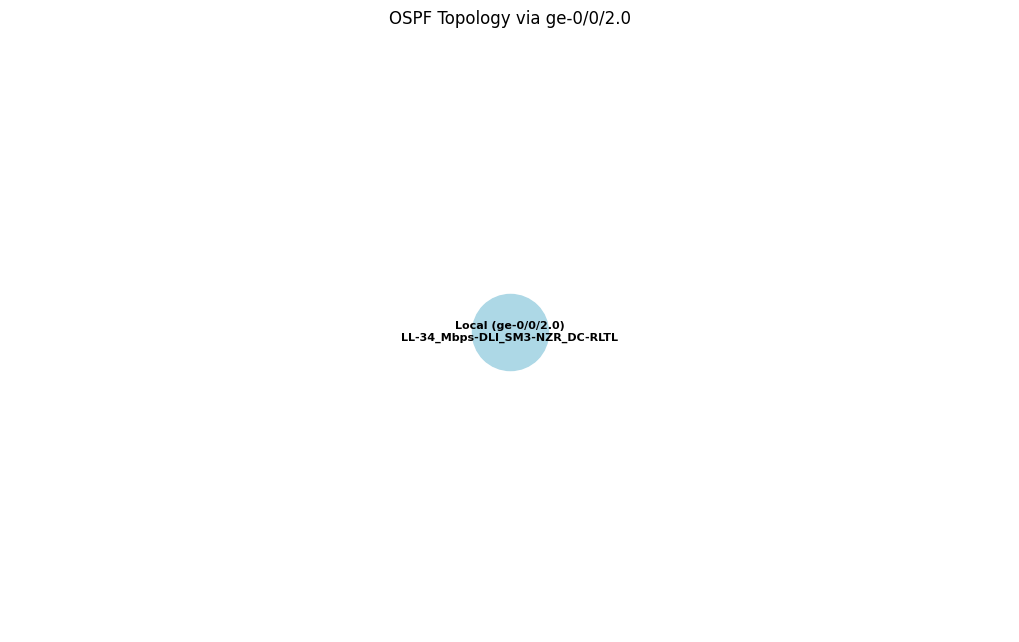

In [ ]:
i

In [ ]:
# Step 1: Install pyvis
!pip install pyvis

# Step 2: Upload the log file
from google.colab import files
uploaded = files.upload()

# Step 3: Imports
import re
from pyvis.network import Network
from IPython.display import IFrame, display

# Step 4: Parsing functions
def parse_ospf_neighbors(log):
    neighbors = []
    pattern = re.compile(r'(\d+\.\d+\.\d+\.\d+)\s+(\S+)\s+(\S+)\s+(\d+\.\d+\.\d+\.\d+)\s+\d+\s+\d+')
    for match in pattern.findall(log):
        local_ip, interface, state, neighbor_ip = match
        neighbors.append((local_ip, neighbor_ip, interface, state))
    return neighbors

def parse_interface_descriptions(log):
    descriptions = {}
    pattern = re.compile(r'(\S+)\s+up\s+up\s+(.+?)\n')
    for match in pattern.findall(log):
        iface, desc = match
        descriptions[iface] = desc.strip()
    return descriptions

# Step 5: Graph generation
def build_network_graph(neighbors, descriptions, filter_state=None, keyword_filter=None, focus_node=None):
    net = Network(height="800px", width="100%", notebook=True, cdn_resources='in_line')
    net.barnes_hut()
    seen_nodes = set()

    for local_ip, neighbor_ip, iface, state in neighbors:
        if filter_state and state.lower() != filter_state.lower():
            continue

        desc = descriptions.get(iface, iface)
        if keyword_filter and keyword_filter.lower() not in desc.lower():
            continue

        # Add nodes
        for ip in [local_ip, neighbor_ip]:
            if ip not in seen_nodes:
                net.add_node(ip, label=ip, color='orange' if ip == focus_node else 'lightblue')
                seen_nodes.add(ip)

        # Add edge with tooltip and label
        net.add_edge(local_ip, neighbor_ip, title=f"{iface}: {desc}", label=desc[:25] + '...' if len(desc) > 25 else desc)

    return net

# Step 6: Load the uploaded log
filename = list(uploaded.keys())[0]
with open(filename, 'r') as f:
    log_data = f.read()

# Step 7: User input
filter_state = input("Filter OSPF State (Full/2Way/Exchange or leave blank): ").strip() or None
keyword_filter = input("Keyword in interface description (e.g., BSNL, PGCIL, RLTL): ").strip() or None
focus_node = input("IP to highlight in orange (optional): ").strip() or None

# Step 8: Parse + Build
ospf_neighbors = parse_ospf_neighbors(log_data)
interface_descriptions = parse_interface_descriptions(log_data)

net = build_network_graph(
    ospf_neighbors,
    interface_descriptions,
    filter_state,
    keyword_filter,
    focus_node
)

# Step 9: Show inside Colab
net.show("ospf_network_map.html")
display(IFrame(src="ospf_network_map.html", width="100%", height=800))

# Step 10: Optional - download for local viewing
files.download("ospf_network_map.html")


Saving putty.log to putty (4).log
Filter OSPF State (Full/2Way/Exchange or leave blank): 2Way
Keyword in interface description (e.g., BSNL, PGCIL, RLTL): PGCIL
IP to highlight in orange (optional): 10.205.35.3
ospf_network_map.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import requests
import time
from datetime import datetime
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from textwrap import wrap
import re

# Store collected reports
domain_reports = []

# Set API Key securely
os.environ["INSIGHT_API_KEY"] = "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"

# -------------------------------------------------------------------
# Utility Functions
# -------------------------------------------------------------------

def sanitize_text(text):
    """Sanitize and clean up non-ASCII or problematic characters."""
    replacements = {
        '\xa0': ' ', '\u2019': "'", '\u2018': "'", '\u201c': '"',
        '\u201d': '"', '\u2014': '-', '\u00a0': ' ', '\u2026': '...'
    }
    for bad, good in replacements.items():
        text = text.replace(bad, good)
    return re.sub(r'[^\x00-\x7F]+', '', text).strip()

# -------------------------------------------------------------------
# Tavily API Integration
# -------------------------------------------------------------------

def fetch_reputation_data(domain):
    """Query Tavily API for domain reputation analysis."""
    api_key = os.getenv("INSIGHT_API_KEY")
    if not api_key:
        return "🚫 Error: API key not found in environment variables."

    query_payload = {
        "query": f"Give a reputation and threat analysis of the domain {domain}.",
        "search_depth": "advanced",
        "include_answer": True,
        "include_raw_content": False
    }

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    try:
        response = requests.post("https://api.tavily.com/search", headers=headers, json=query_payload)
        response.raise_for_status()
        data = response.json()
        formatted = create_detailed_report(domain, data)
        domain_reports.append((domain, formatted))
        return formatted

    except requests.exceptions.HTTPError as e:
        return f"❌ HTTP Error: {e.response.status_code} - {e.response.reason}"
    except Exception as e:
        return f"❌ Request Failed: {str(e)}"

# -------------------------------------------------------------------
# Report Formatting
# -------------------------------------------------------------------

def create_detailed_report(domain, data):
    """Format the report content for the given domain."""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    summary = sanitize_text(data.get("answer", "No summary available."))

    lines = [
        "=" * 100,
        "🛡️ INSIGHTSHIELD | DOMAIN INTELLIGENCE REPORT",
        f"📅 Timestamp         : {timestamp}",
        f"🌐 Analyzed Domain   : {domain}",
        f"🗣️ Languages         : English | हिंदी",
        "=" * 100,
        "\n🔍 Summary Insight",
        "-" * 100,
        summary,
        ""
    ]

    sources = data.get("results", [])
    if sources:
        lines.append("📚 Reviewed Intelligence Sources")
        lines.append("-" * 100)
        for i, source in enumerate(sources[:5], 1):
            url = source.get("url", "Unknown URL")
            content = sanitize_text(source.get("content", "No description."))
            lines.append(f"{i}. 🔗 {url}")
            for wrapped in wrap(content, 90):
                lines.append(f"    {wrapped}")
            lines.append("")
    else:
        lines.append("⚠️ No supporting sources provided.")

    if data.get("related_searches"):
        lines.append("🔎 Related Search Queries")
        lines.append("-" * 100)
        for search in data["related_searches"]:
            lines.append(f"• {search}")
        lines.append("")

    lines.append("✅ End of Domain Report")
    lines.append("=" * 100 + "\n")
    return "\n".join(lines)

# -------------------------------------------------------------------
# PDF Export
# -------------------------------------------------------------------

def export_reports_to_pdf(filename=None):
    """Generate a printable PDF report from stored domain checks."""
    if not domain_reports:
        print("📭 No reports to export.")
        return

    if not filename:
        filename = f"InsightShield_Report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf"

    c = canvas.Canvas(filename, pagesize=A4)
    width, height = A4
    margin = 50
    y = height - margin
    font_size = 10
    line_height = 14
    footer = "© 2025 InsightShield | Confidential Cyber Intelligence Report"
    wrap_limit = 100

    c.setFont("Helvetica", font_size)

    for domain, report in domain_reports:
        lines = sanitize_text(report).split("\n")

        # Header per report
        c.setFont("Helvetica-Bold", font_size)
        c.drawString(margin, y, f"📘 Reputation Check: {domain}")
        y -= line_height * 2
        c.setFont("Helvetica", font_size)

        for line in lines:
            if not line.strip():
                y -= line_height
                continue
            for segment in wrap(line, wrap_limit):
                if y <= 40:
                    c.setFont("Helvetica-Oblique", 8)
                    c.drawCentredString(width / 2, 25, footer)
                    c.showPage()
                    c.setFont("Helvetica", font_size)
                    y = height - margin
                c.drawString(margin, y, segment)
                y -= line_height
        y -= line_height * 2

    c.setFont("Helvetica-Oblique", 8)
    c.drawCentredString(width / 2, 25, footer)
    c.save()
    print(f"📄 Report successfully exported as: {filename}")

# -------------------------------------------------------------------
# Command-Line Interface
# -------------------------------------------------------------------

def menu():
    print("\n🧠 Welcome to InsightShield – Real-time Domain Reputation Checker")
    print("=" * 65)

    while True:
        print("\nMenu Options:\n1️⃣ Check Domain Reputation\n2️⃣ Export Reports to PDF\n3️⃣ Exit")
        user_choice = input("🔸 Enter your choice (1/2/3): ").strip()

        if user_choice == "1":
            domain = input("🌐 Enter domain (e.g., example.com): ").strip()
            if domain:
                print("\n⏳ Querying Tavily API. Please wait...\n")
                report_output = fetch_reputation_data(domain)
                print(report_output)
            else:
                print("⚠️ Please enter a valid domain.")
        elif user_choice == "2":
            export_reports_to_pdf()
        elif user_choice == "3":
            print("👋 Exiting InsightShield. Stay cyber-safe!")
            break
        else:
            print("❌ Invalid input. Please choose 1, 2, or 3.")

# -------------------------------------------------------------------
# Main Execution
# -------------------------------------------------------------------

if __name__ == "__main__":
    menu()



🧠 Welcome to InsightShield – Real-time Domain Reputation Checker

Menu Options:
1️⃣ Check Domain Reputation
2️⃣ Export Reports to PDF
3️⃣ Exit


KeyboardInterrupt: Interrupted by user